Initialization and Preprocessing of Image Data for Model Training

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
import os

# Load and preprocess image data from a directory
# This function initializes image data generators for training and validation datasets with transformations.
# The function sets up the data in TensorFlow datasets.
# It also calculates class weights to handle imbalanced data.
# Parameters:
# - data_dir: The directory from which to load the images.
# - target_size: The dimensions to which the images will be resized.
# - batch_size: The number of images in each batch.
# - crop_size: The dimensions used for random cropping of images.
# - validation_split: The fraction of the data to reserve for validation.
# Returns:
# - train_dataset: The dataset object for training data.
# - validation_dataset: The dataset object for validation data.
# - num_classes: The number of unique classes in the dataset.
# - class_weights_dict: A dictionary mapping class indices to their respective weights.
# - train_steps_per_epoch: The number of batches per epoch for training.
# - val_steps: The number of batches per epoch for validation.
def load_data(data_dir, target_size=(519, 224), batch_size=16, crop_size=(224, 224), validation_split=0.2):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split,
        rotation_range=4,  
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        zoom_range=0.1,
        brightness_range=(0.6, 1.2),
        fill_mode='nearest',
        cval=0,
    )
    
    # Create a validation data generator
    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split
    )

    # Create train and validation generators
    # Note we did not use a Test set since we dont have enough data. It was already not enough training data, even with the validation set only.
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = validation_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    # Get class indices and counts
    class_indices = train_generator.class_indices
    num_classes = len(class_indices)
    
    # Get the list of classes and the number of samples per class
    class_samples = train_generator.classes
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(class_samples),
        y=class_samples
    )
    class_weights_dict = dict(enumerate(class_weights))
     
    # Apply random cropping to the images in the dataset
    def random_crop_batch(images):
        cropped_images = tf.map_fn(
            lambda img: tf.image.random_crop(img, size=[crop_size[0], crop_size[1], 3]),
            images
        )
        return cropped_images

    def preprocess_image(images, labels):
        images = random_crop_batch(images)
        return images, labels

    # Create a dataset from the generator
    def generator_to_dataset(generator):
        dataset = tf.data.Dataset.from_generator(
            lambda: generator,
            output_signature=(
                tf.TensorSpec(shape=(None, *target_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
            )
        )
        dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        # dataset = dataset.batch(batch_size)
        # dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return dataset
    
    train_dataset = generator_to_dataset(train_generator)
    validation_dataset = generator_to_dataset(validation_generator)
    
    train_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
    val_steps = np.ceil(validation_generator.samples / batch_size)

    return train_dataset, validation_dataset, num_classes, class_weights_dict, train_steps_per_epoch ,val_steps

train_dataset, validation_dataset, num_classes, class_weights, train_steps_per_epoch, val_steps  = load_data("data/")

print(train_steps_per_epoch)

Found 538 images belonging to 2 classes.
Found 133 images belonging to 2 classes.
34.0


Visualizing Preprocessed Images 

(16, 2)
(16, 224, 224, 3)


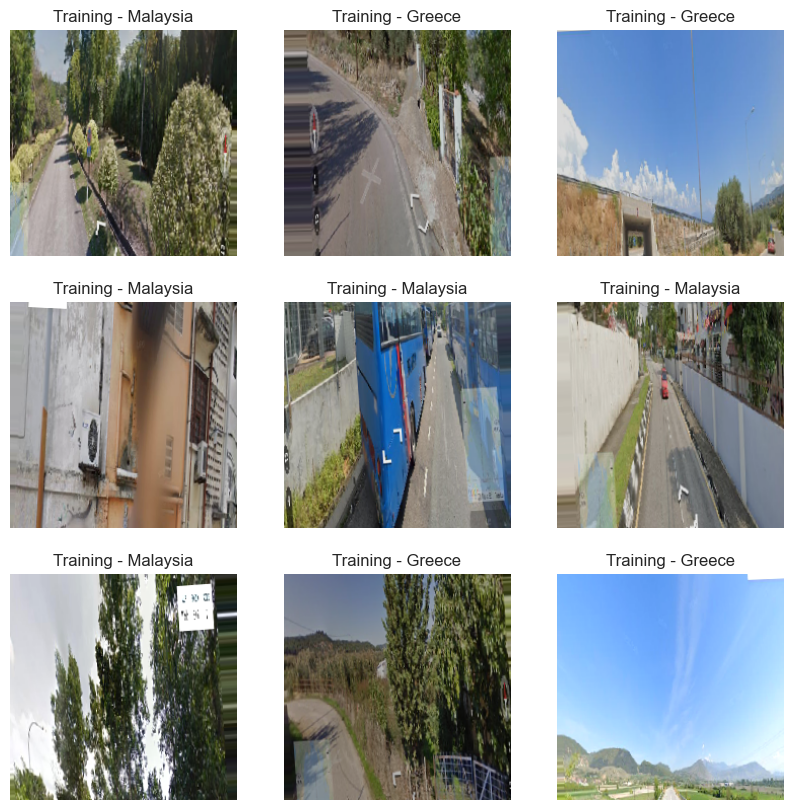

(16, 2)
(16, 224, 224, 3)


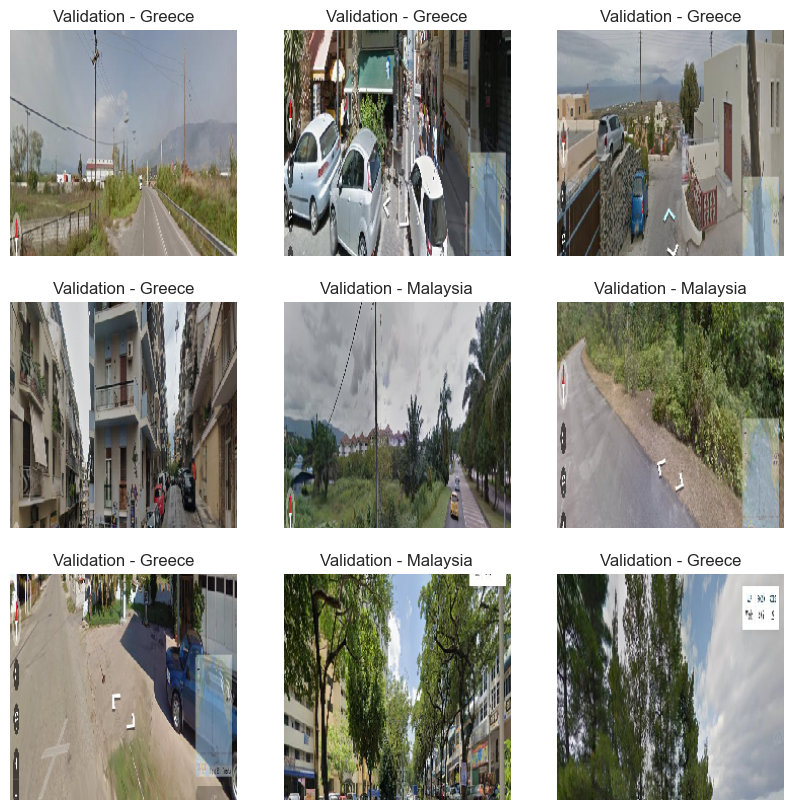

In [31]:
import matplotlib.pyplot as plt

# Visualize images from a TensorFlow dataset
# This function displays a 3x3 grid of images from the provided dataset to help visualize data preprocessing and augmentation effects.
# Each image is displayed with a corresponding label from the dataset.
# Parameters:
# - dataset: The TensorFlow dataset from which to visualize images.
# - title: A title for the visualization, typically indicating whether the data is from training or validation set.
# - classes: A list of class names corresponding to label indices, used to annotate images with human-readable class names.

def visualize_dataset(dataset, title, classes):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        print(labels.shape)
        
        print(images.shape)
        for i in range(9):
            label = classes[int(labels[i][1])]
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(title + " - " + label)
            plt.axis("off")
    plt.show()

classes = ["Greece", "Malaysia"]
visualize_dataset(train_dataset, "Training", classes)

visualize_dataset(validation_dataset, "Validation", classes)


Setting Up a Transfer Learning Model with ResNet152

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the ResNet152 model pre-trained on ImageNet without the top layer
base_model = tf.keras.applications.ResNet152(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Assemble a new model on top of the base model with added layers for classification
# Freeze the layers of the base model to retain learned features during training
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 58,375,042
Trainable params: 58,223,618
Non-trainable params: 151,424
_________________________________________________________________


Configuring TensorFlow GPU Settings for Enhanced Performance

In [34]:
# Identify and list all available GPUs in the system
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        # Use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:checkpoint_filepath = 'model_checkpoint.h5'


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

Compiling the Model for Training

In [35]:
# Compile the model with an Adam optimizer and categorical cross-entropy loss
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Training the Model with Checkpointing and GPU Acceleration

In [36]:
# Define the model checkpoint callback to save the best model based on validation loss
checkpoint_filepath = 'model_checkpoint.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Specify that the model training should run on the first GPU
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        steps_per_epoch=train_steps_per_epoch,
        epochs=100,
        validation_data=validation_dataset,
        validation_steps=val_steps,
        class_weight=class_weights,
        callbacks=[checkpoint_callback] 

    )
model.load_weights(checkpoint_filepath)

Epoch 1/100
34/34 [==============================] - 28s 486ms/step - loss: 1.2593 - accuracy: 0.5762 - val_loss: 7079814963920896.0000 - val_accuracy: 0.3083
Epoch 2/100
34/34 [==============================] - 12s 344ms/step - loss: 1.0467 - accuracy: 0.5297 - val_loss: 122215825408.0000 - val_accuracy: 0.3684
Epoch 3/100
34/34 [==============================] - 13s 397ms/step - loss: 0.8803 - accuracy: 0.5874 - val_loss: 462605952.0000 - val_accuracy: 0.3684
Epoch 4/100
34/34 [==============================] - 13s 390ms/step - loss: 0.6993 - accuracy: 0.6301 - val_loss: 0.6910 - val_accuracy: 0.6090
Epoch 5/100
34/34 [==============================] - 13s 378ms/step - loss: 0.7441 - accuracy: 0.6468 - val_loss: 0.6914 - val_accuracy: 0.5789
Epoch 6/100
34/34 [==============================] - 14s 413ms/step - loss: 0.6720 - accuracy: 0.6468 - val_loss: 0.6855 - val_accuracy: 0.6391
Epoch 7/100
34/34 [==============================] - 13s 385ms/step - loss: 0.7515 - accuracy: 0.6171 

Visualizing Training Progress: Accuracy and Loss Curves

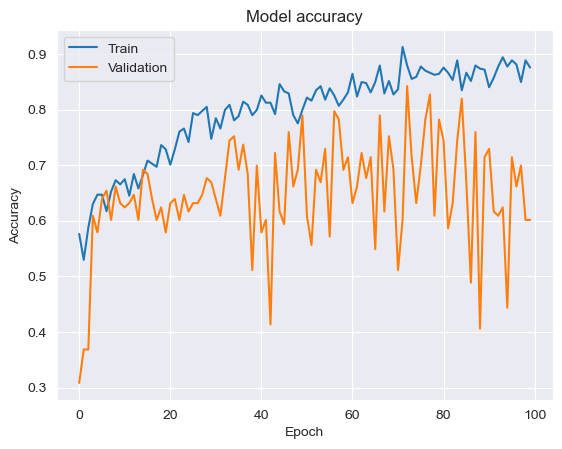

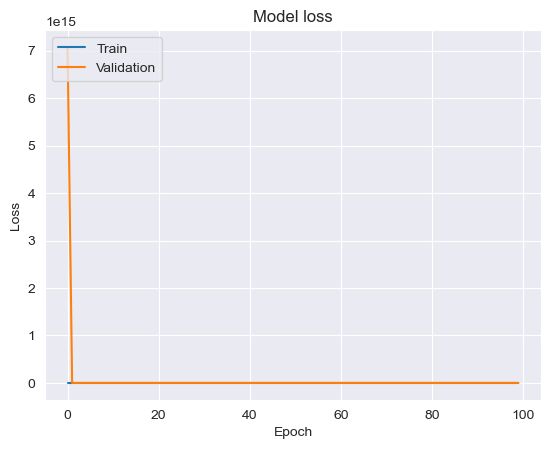

In [37]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Confusion Matrix and Classification Visualizations

1/1 [==============================] - 0s 28ms/step


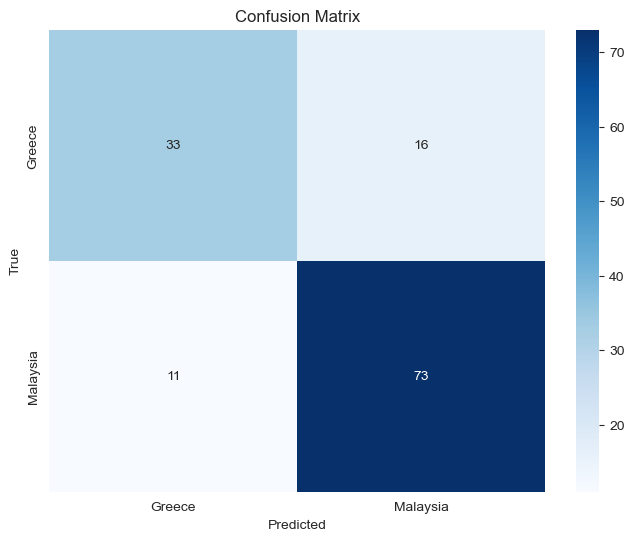

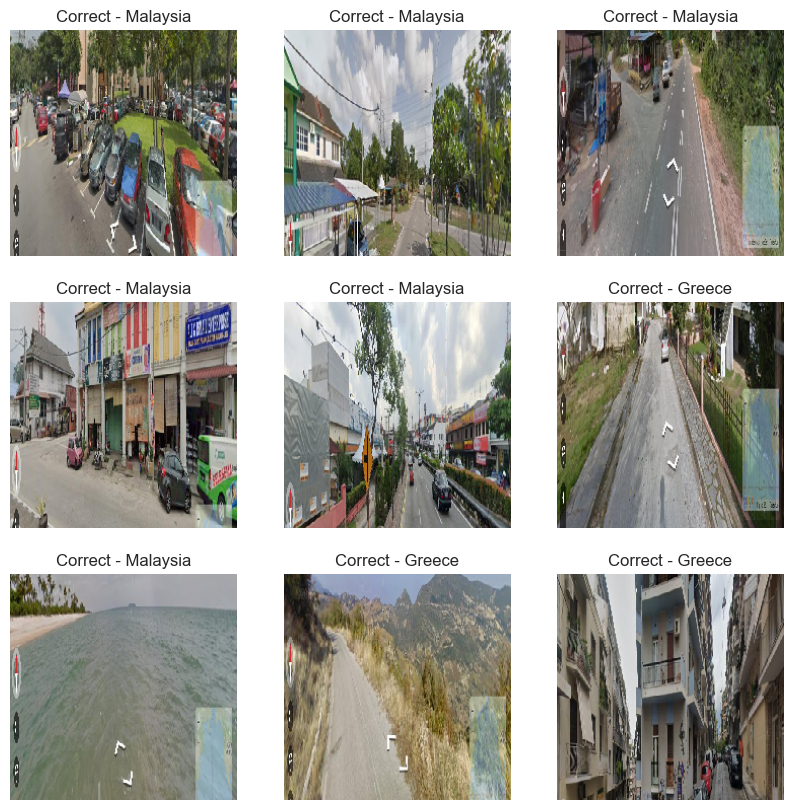

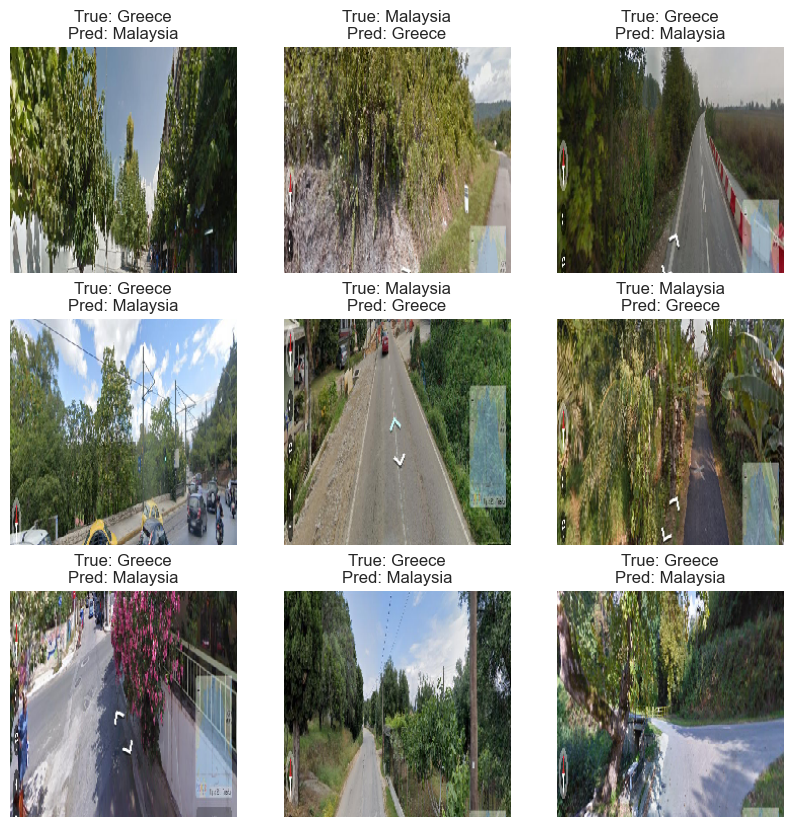

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


y_true = []
y_pred = []
# Lists to store correctly and incorrectly classified images for visualization
correctly_classified = []
incorrectly_classified = []

# Iterate over the validation dataset to collect predictions and compare against true labels
for images, labels in validation_dataset.take(val_steps):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    
    true_labels = tf.argmax(labels, axis=1)
    y_true.extend(true_labels.numpy())
    y_pred.extend(predicted_labels.numpy())
    
    # Get the images that were correctly and incorrectly classified
    for i in range(len(true_labels)):
        if true_labels[i] == predicted_labels[i]:
            correctly_classified.append((images[i], true_labels[i]))
        else:
            incorrectly_classified.append((images[i], true_labels[i], predicted_labels[i]))

# Plot confusion matrix to visualize classification accuracy
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




# Visualize 9 correctly classified images
plt.figure(figsize=(10, 10))
for i in range(min(9, len(correctly_classified))):
    image, label = correctly_classified[i]
    label = classes[int(label)]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title("Correct - " + label)
    plt.axis("off")
plt.show()

# Visualize 9 incorrectly classified images
plt.figure(figsize=(10, 10))
for i in range(min(9, len(incorrectly_classified))):
    image, true_label, predicted_label = incorrectly_classified[i]
    true_label = classes[int(true_label)]
    predicted_label = classes[int(predicted_label)]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis("off")
plt.show()